`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   

In [1]:
# настройка ширины страницы блокнота .......................................
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# расширение watermark для вывода информации о версиях пакетов
#  https://github.com/rasbt/watermark
# установка: командная строка - pip install watermark
%load_ext watermark

# Лабораторная работа №4: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг.  

В практических примерах ниже показано:   

* как делать перекодировку признаков в номинальной и порядковой шкалах
* как вырастить дерево и сделать обрезку его ветвей    
* как настроить модель бустинга на деревьях решений  
* как подбирать настроечные параметры моделей методом сеточного поиска  

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.  

*Модели*: дерево классификации, бэггинг, случайный лес, бустинг, дерево регрессии  
*Данные*: `winequality-white_for_lab`. Источник: https://raw.githubusercontent.com/ania607/ML/main/data/winequality-white_for_lab.csv

In [2]:
# выводим информацию о версиях python и пакетов
%watermark -a "Joseph Demin" -d -v -p numpy,pandas,matplotlib,sklearn 

Author: Joseph Demin

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

numpy     : 1.21.5
pandas    : 1.4.4
matplotlib: 3.5.2
sklearn   : 1.1.1



# Указания к выполнению


## Загружаем пакеты

In [3]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
#  для таймера
import time

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
#  сводка по точности классификации
from sklearn.metrics import classification_report

In [4]:
# константы
#  ядро для генератора случайных чисел
my_seed = 6
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [5]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
    
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)


# функция, которая строит график важности признаков в модели случайного леса
#  источник: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
                      inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

## Загружаем данные

Набор данных можно загрузить напрямую по ссылке: <https://raw.githubusercontent.com/ania607/ML/main/data/winequality-white_for_lab.csv>. Справочник к данным доступен по адресу: <https://github.com/ania607/ML/blob/main/data/CodeBook_winequality-white_for_lab.md.txt>.    

Загружаем данные во фрейм и выясняем их размерность. В таблице много строк, поэтому для экономии времени загрузку сделаем в два шага: сначала скачаем таблицу и сохраним в папку `'./data'`, затем прочитаем её во фрейм. Перед скачиванием проверим, нет ли уже такого файла в папке с данными.  

In [6]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/winequality-white_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (4898, 13)


In [7]:
# типы столбцов
DF_raw.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Y                         int64
dtype: object

Проблема в том, что, судя по справочнику к данным, все столбцы таблицы являются категориальными. Однако некоторые (бинарные) воспринимаются как `int`, а остальные как `object`. Посмотрим на столбцы типа `int`.   

In [8]:
# первые 7 строк столбцов типа int64
DF_raw.loc[:, DF_raw.columns[DF_raw.dtypes == 'int64']].head(7)

,quality,Y
0,6,1
1,6,1
2,6,1
3,6,1
4,6,1
5,6,1
6,6,1


Функция построения дерева классификации `DecisionTreeClassifier()` требует числовых порядковых значений переменных. Видно, что столбцы типа `int64` либо порядковые (`temperature`), либо бинарные (все остальные), их преобразовывать нет необходимости. А вот столбцы типа `object` придётся кодировать вручную.  
При этом на этапе предварительного анализа данных нам удобнее будет работать с исходными категориальными столбцами. Поэтому сейчас просто изменим тип столбцов `object` на `category`.  

In [9]:
# меняем тип столбцов на категориальные
#for col in DF_raw.columns[DF_raw.dtypes == 'object'] :
 #   DF_raw[col] = DF_raw[col].astype('category')

Отложим 15% наблюдений для прогноза.  

In [10]:
# наблюдения для моделирования
DF = DF_raw.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_raw.drop(DF.index)

In [11]:
# выбрасываем стобцы с большинством пропусков или с нулевой дисперсией
#  из обучающей выборки
DF = DF.drop(['quality'], axis=1)
#  и из отложенных наблюдений
DF_predict = DF_predict.drop(['quality'], axis=1)

# Предварительный анализ данных  

## Описательные статистики  

Стандартный подсчёт статистик с помощью фунции `describe()` .   

Ещё раз оценим количество пропусков.  

In [12]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [13]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 5)

1    0.66442
0    0.33558
Name: Y, dtype: float64

In [14]:
# описательные статистики
DF.iloc[:, :].describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
count,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,6.849135,0.278086,0.333541,6.366731,0.045917,35.201417,138.328369,0.994012,3.189784,0.489926,10.522423,0.664425
std,0.844912,0.100482,0.118623,5.088573,0.022027,17.003168,42.613313,0.003013,0.151397,0.113545,1.233513,0.472248
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991700,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.100000,0.043000,34.000000,134.000000,0.993700,3.180000,0.480000,10.400000,1.000000
75%,7.300000,0.320000,0.380000,9.800000,0.050000,45.000000,168.000000,0.996100,3.280000,0.550000,11.400000,1.000000
max,14.200000,1.100000,1.230000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,1.000000


In [15]:
# считаем пропуски в столбцах, выводим ненулевые значения
nas = DF.isna().sum()
nas = np.around(nas / DF.shape[0], 3)
nas[nas > 0]

Series([], dtype: float64)

Пропусков нет.

## Распределение предикторов внутри классов  по зависимой переменной

Все объясняющие переменные являются категориальными, поэтому оценивать их связь с зависимой переменной с помощью корреляционной матрицы некорректно. Вместо этого можно воспользоваться [критерием согласия Хи-квадрат](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%81%D0%BE%D0%B3%D0%BB%D0%B0%D1%81%D0%B8%D1%8F_%D0%9F%D0%B8%D1%80%D1%81%D0%BE%D0%BD%D0%B0), который рассчитывается по таблице сопряжённости. Нулевая гипотеза теста: распределение долей в таблице сопряжённости случайно, т.е. два показателя независимы друг от друга.     
Проведём тест для всех пар "объясняющая переменная" – "зависимая переменная" и выведем те пары, для которых соответствующее критерию p-значение больше 0.05 (т.е. нулевая гипотеза принимается, переменные независимы).  

In [17]:
for col in DF.columns[:8] :
    con_tab = pd.crosstab(DF[col], DF['Y'])
    c, p, dof, expected = chi2_contingency(con_tab)
    if p > 0.05 :
        print(col, 'и Y',
              '\nH_0: переменные распределены независимо друг от друга', 
              '\nP-значение:', np.around(p, 4))

Интересный результат: полное совпадение p-значений – объясняется тем, что на самом деле `direction_same` и `direction_opp` противоположны друг другу. Связь между ними функциональная: если направление на ресторан/кофейню, в который предлагается купон, не совпадает с направлением на исходное место назначения (`direction_same == 0`), то оно противоположно (`direction_opp == 1`), и наоборот. Поэтому в модель имеет смысл включать только одну из этих переменных.   

## Перекодировка номинальной и порядковой шкалы    

Перекодировка не треубуется так как исходные данные уже заходированы.

In [18]:
# чтобы меньше исправлять
DF_num = DF

# результат
DF_num.head()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
3765,6.9,0.40,0.17,12.9,0.033,59.0,186.0,0.99754,3.08,0.49,9.4,0
154,8.2,0.23,0.40,7.5,0.049,12.0,76.0,0.99660,3.06,0.84,9.7,1
1383,7.1,0.36,0.56,1.3,0.046,25.0,102.0,0.99230,3.24,0.33,10.5,1
568,6.1,0.26,0.51,2.2,0.050,61.0,154.0,0.99290,3.08,0.60,9.8,1
1338,6.7,0.18,0.30,6.4,0.048,40.0,251.0,0.99560,3.29,0.52,10.0,0


In [19]:
# чтоб меньше исправлять
DF_predict_num = DF_predict

# результат
DF_predict_num.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,1
13,6.6,0.16,0.40,1.5,0.044,48.0,143.0,0.9912,3.54,0.52,12.4,1
17,6.2,0.66,0.48,1.2,0.029,29.0,75.0,0.9892,3.33,0.39,12.8,1
19,6.5,0.31,0.14,7.5,0.044,34.0,133.0,0.9955,3.22,0.50,9.5,0
23,7.6,0.67,0.14,1.5,0.074,25.0,168.0,0.9937,3.05,0.51,9.3,0


# Модель дерева  

В этом разделе построим:  

* дерево классификации  
* дерево классификации с обрезкой ветвей  


## Дерево на всех признаках    

Построим модель и выведем изображение дерева в виде текста.  

In [21]:
# выращиваем дерево на всех объясняющих
X = DF_num.drop(['Y'], axis=1)
y = DF_num['Y']

# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
                                      random_state=my_seed)

tree_full = cls_one_tree.fit(X, y)

# выводим количество листьев (количество конечных узлов)
tree_full.get_n_leaves()

554

In [22]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
tree_full.get_depth()

19

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой.   

In [23]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
                     scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели one_tree : 0.763


## Дерево с обрезкой ветвей   

Подберём оптимальное количество ветвей, которое максимизирует $Acc$, для экономии времени рассчитанный методом проверочной выборки.  

In [24]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 329
Энтропия листьев для первых 5 значений alpha: [0.         0.00048042 0.00096085 0.00144127 0.00192169]


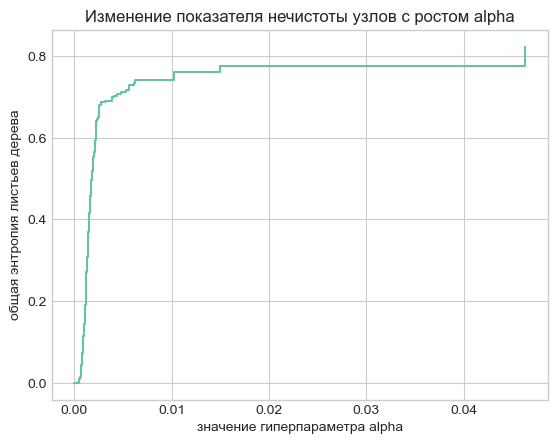

In [25]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker=',', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [26]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=my_seed)

# модели
clfs = list()

# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 10.00 секунд


In [27]:
# извлекаем характеристики глубины и точности
#  таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
#  таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 1.18 секунд


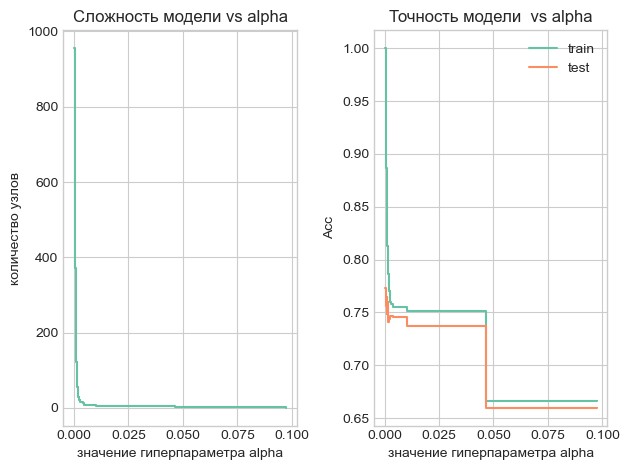

In [28]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)

# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")

# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
           drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
           drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели  vs alpha")
ax[1].legend()
fig.tight_layout()

Находим оптимальный размер дерева по максимуму $Acc$ на тестовой выборке.  

Посмотрим на характеристики глубины и сложности построенного дерева с обрезкой ветвей.

---

📚 **Пример визуализации небольшого дерева**

Лучшее дерево с обрезкой по-прежнему слишком велико для визуализации. Для примера нарисуем одно из небольших деревьев с обрезкой и выведем его же в виде текста.  

In [30]:
# находим деревья с количеством листьев меньше 20
[i for i in node_counts if i < 20]

[19, 19, 19, 17, 17, 13, 13, 9, 9, 9, 9, 9, 9, 5, 5, 5, 3, 1]

In [108]:
plot_tree?

Количество узлов: 19 
Точность дерева на тестовой: 0.746


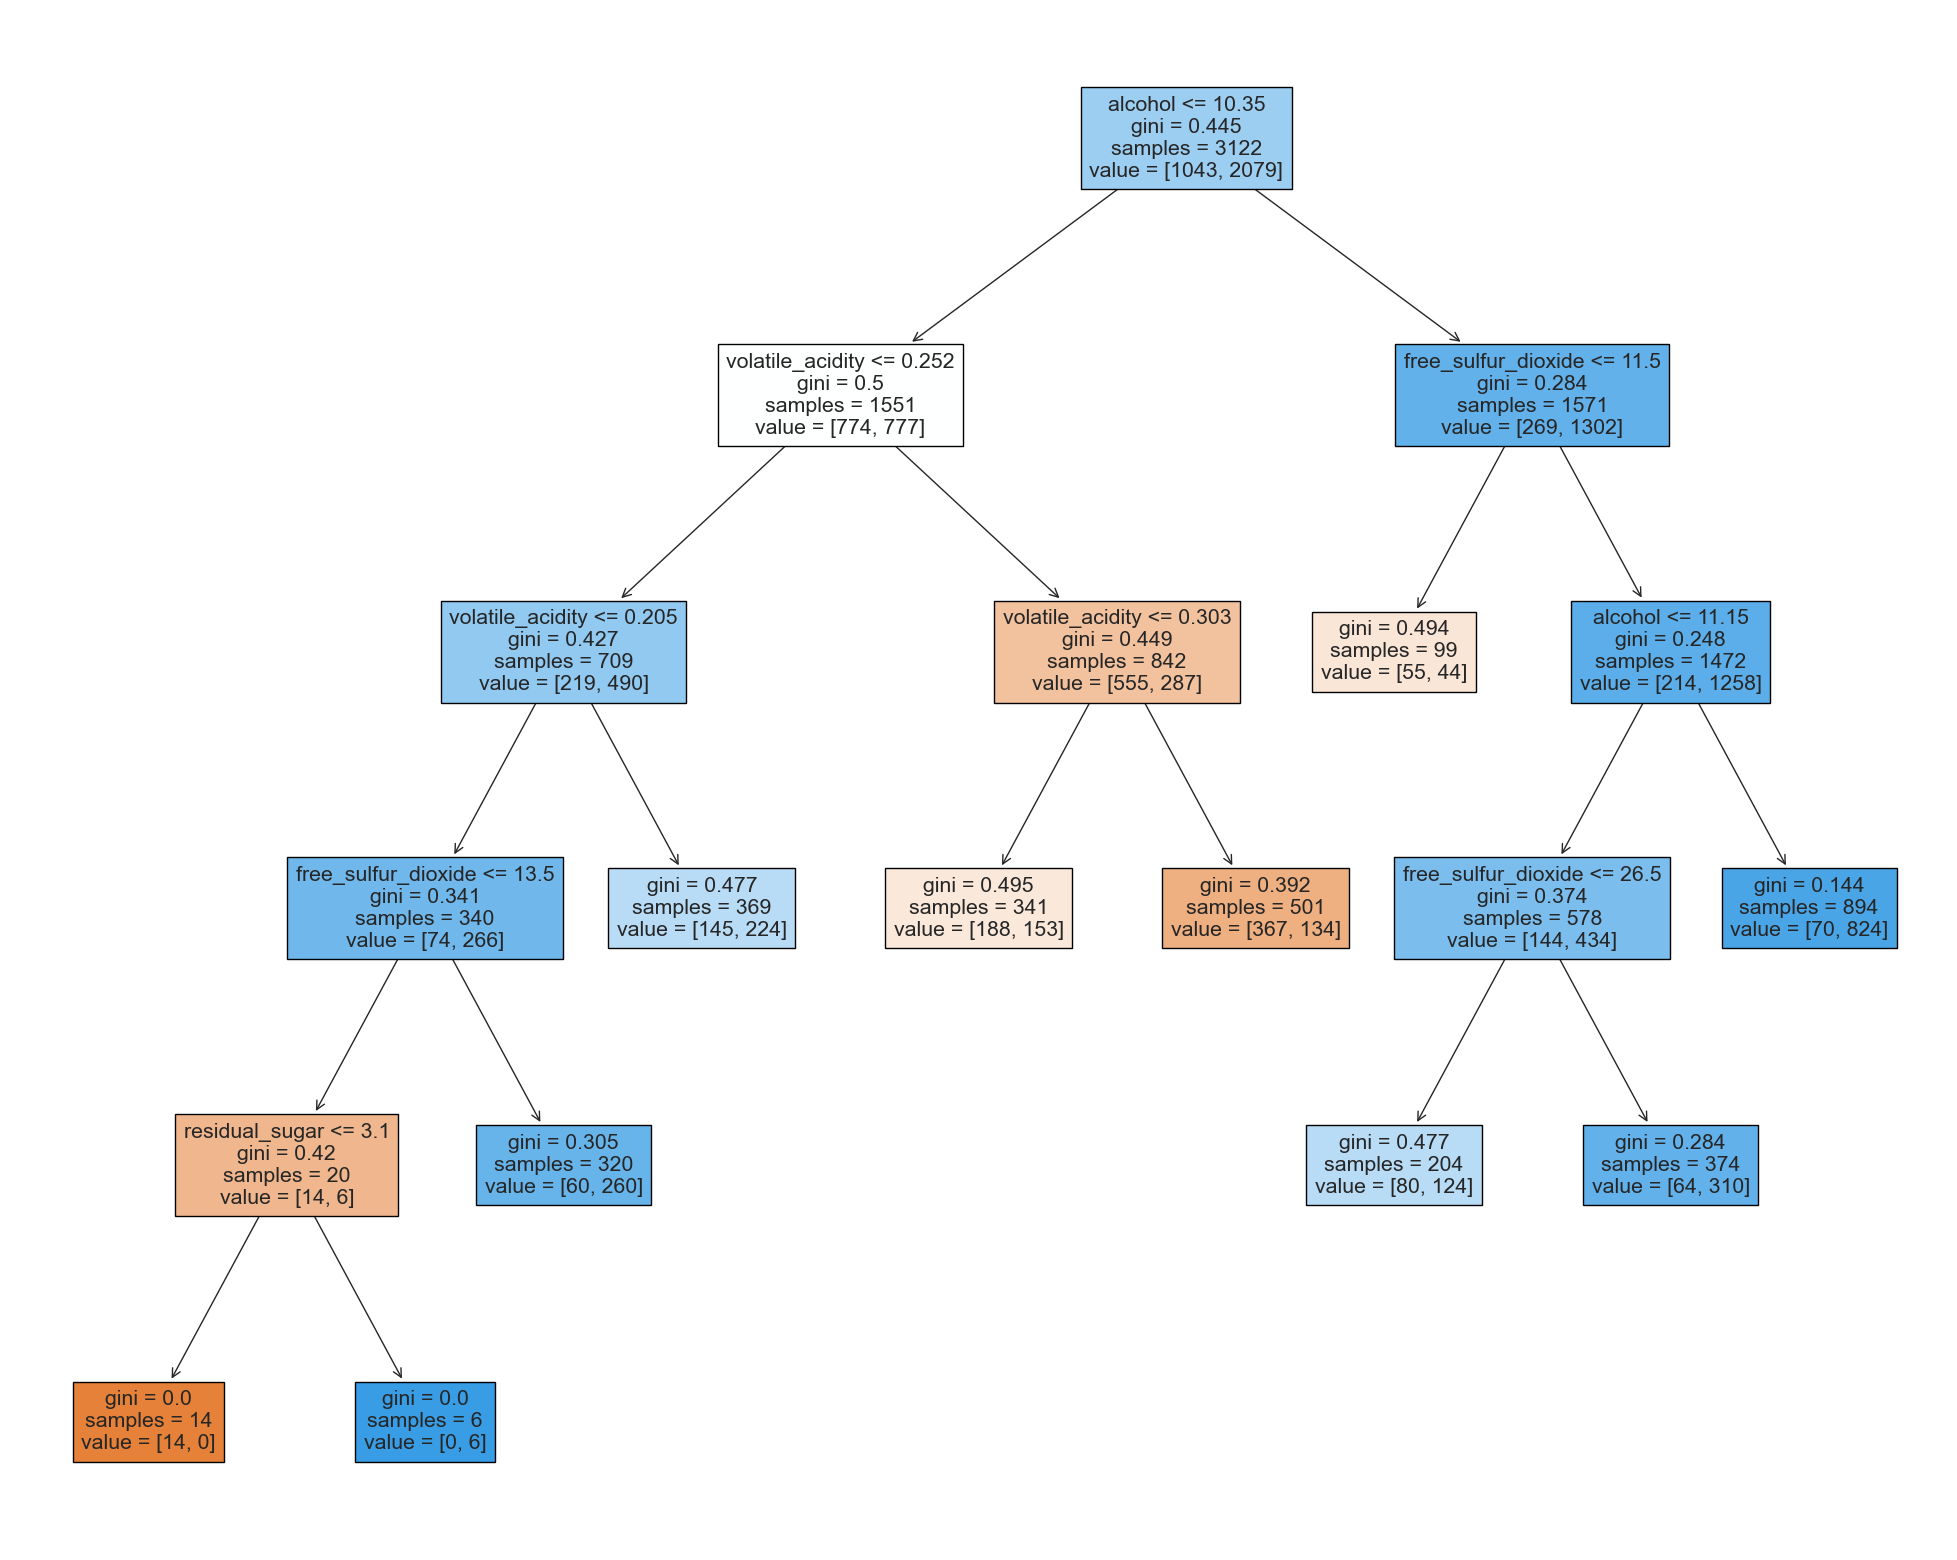

In [33]:
# визуализация на схеме НА ПРИМЕРЕ МАЛЕНЬКОГО ДЕРЕВА
nodes_num = 19
print('Количество узлов:', nodes_num,
      '\nТочность дерева на тестовой:', 
      np.around(test_scores[node_counts.index(nodes_num)], 3))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], 
              filled=True, 
              feature_names=list(X.columns))

In [34]:
# визуализируем дерево в виде текстовой схемы
viz = export_text(clfs[node_counts.index(nodes_num)], 
                  feature_names=list(X.columns))
print(viz)

|--- alcohol <= 10.35
|   |--- volatile_acidity <= 0.25
|   |   |--- volatile_acidity <= 0.20
|   |   |   |--- free_sulfur_dioxide <= 13.50
|   |   |   |   |--- residual_sugar <= 3.10
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- residual_sugar >  3.10
|   |   |   |   |   |--- class: 1
|   |   |   |--- free_sulfur_dioxide >  13.50
|   |   |   |   |--- class: 1
|   |   |--- volatile_acidity >  0.20
|   |   |   |--- class: 1
|   |--- volatile_acidity >  0.25
|   |   |--- volatile_acidity <= 0.30
|   |   |   |--- class: 0
|   |   |--- volatile_acidity >  0.30
|   |   |   |--- class: 0
|--- alcohol >  10.35
|   |--- free_sulfur_dioxide <= 11.50
|   |   |--- class: 0
|   |--- free_sulfur_dioxide >  11.50
|   |   |--- alcohol <= 11.15
|   |   |   |--- free_sulfur_dioxide <= 26.50
|   |   |   |   |--- class: 1
|   |   |   |--- free_sulfur_dioxide >  26.50
|   |   |   |   |--- class: 1
|   |   |--- alcohol >  11.15
|   |   |   |--- class: 1



---

# Бэггинг  

Модель бэггинга использует бутстреп, чтобы вырастить $B$ деревьев на выборках с повторами из обучающих данных. Построим модель для $B=50$ деревьев.  

In [35]:
# параметр B: количество деревьев
num_trees = 50

# разбиения для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# таймер
tic = time.perf_counter()
# модель с бэггингом
tree_bag = BaggingClassifier(base_estimator=cls_one_tree,
                             n_estimators=num_trees,
                             random_state=my_seed)

cv = cross_val_score(tree_bag, X, y, cv=kfold)

# таймер
toc = time.perf_counter()
print(f"Обучение модели с бэггингом на {num_trees:0.0f} деревьях", 
      " и перекрёстной проверкой ", 
      f"заняло {toc - tic:0.2f} секунд", sep='')

Обучение модели с бэггингом на 50 деревьях и перекрёстной проверкой заняло 7.97 секунд


In [36]:
# точность
np.around(np.mean(cv), 3)

0.82

Итак, мы построили модель, выбрав параметр $B$ случайным образом. Воспользуемся функцией `GridSearchCV()`, чтобы перебрать 5 вариантов значений для параметра $B$.  

In [37]:
# настроим параметры бэггинга с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50]}

# таймер
tic = time.perf_counter()
clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()),
                  param_grid, scoring='accuracy', cv=kfold)

tree_bag = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 15.50 секунд


In [38]:
# точность лучшей модели
np.around(tree_bag.best_score_, 3)

0.822

In [39]:
# количество деревьев у лучшей модели
tree_bag.best_params_

{'n_estimators': 50}

In [40]:
tree_bag.best_estimator_.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Таким образом, перебрав несколько вариантов для $B$, мы немного улучшили первоначальную точность модели бэггинга.  

In [62]:
# записываем точность
score.append(np.around(tree_bag.best_score_, 3))
score_models.append('bagging_GS')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[1], ':', score[1])

Acc с перекрёстной проверкой 
для модели bagging_GS : 0.822


# Случайный лес  



У модели случайного леса два настроечных параметра: количество деревьев $B$ и количество признаков для построения отдельного дерева $m$. Настроим сеточный поиск для их подбора.  

In [42]:
# сколько столбцов в обучающих данных (p)
X_m = X.shape[1]
# возьмём значения для m: p, p/2, sqrt(p) и log2(p)
ms = np.around([X_m, X_m / 2, np.sqrt(X_m), np.log2(X_m)]).astype(int)
ms

array([11,  6,  3,  3])

In [43]:
# настроим параметры случайного леса с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50],
              'max_features' : ms}

# таймер
tic = time.perf_counter()
clf = GridSearchCV(RandomForestClassifier(DecisionTreeClassifier()),
                   param_grid, scoring='accuracy', cv=kfold)
random_forest = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 32.37 секунд


In [44]:
# точность лучшей модели
np.around(random_forest.best_score_, 3)

0.828

In [45]:
# количество деревьев у лучшей модели
random_forest.best_estimator_.get_params()['n_estimators']

50

In [46]:
# количество объясняющих у лучшей модели
random_forest.best_estimator_.get_params()['max_features']

3

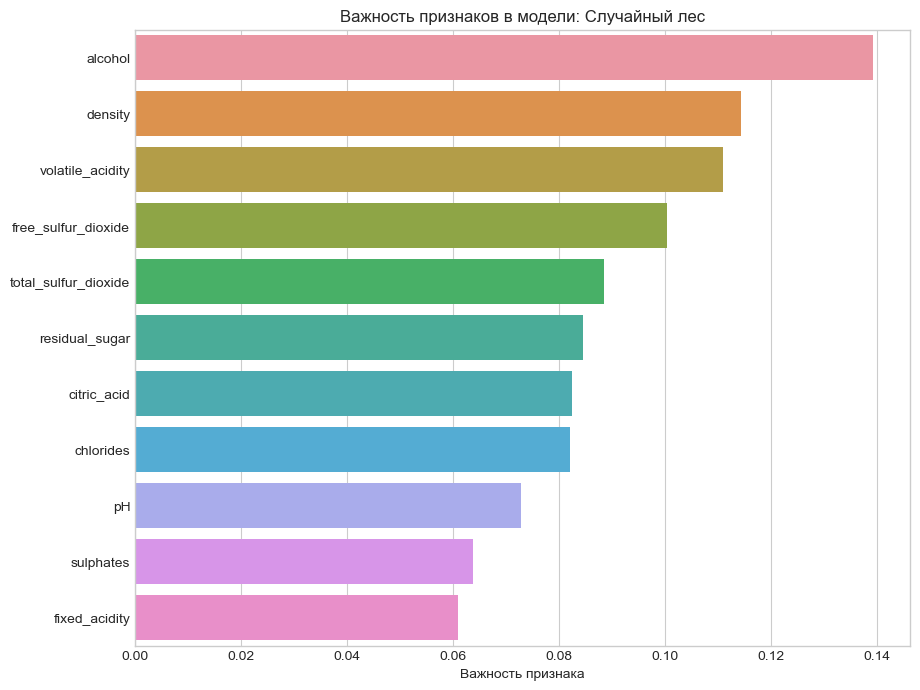

In [47]:
# рисуем график относительной важности каждого признака
plot_feature_importance(random_forest.best_estimator_.feature_importances_,
                        X.columns, 'Случайный лес')

In [61]:
# записываем точность
score.append(np.around(random_forest.best_score_, 3))
score_models.append('random_forest_GS')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[2], ':', score[2])

Acc с перекрёстной проверкой 
для модели random_forest_GS : 0.828


# Бустинг 



Подберём сеточным поиском настроечные параметры модели:  
* $B$ число деревьев, 
* $\lambda$ – скорость обучения,
* $d$ – глубина взаимодействия предикторов.

In [49]:
# обучаем модель с параметрами по умолчанию
clf_tst = GradientBoostingClassifier(n_estimators=100, learning_rate=1,
                                    max_depth=1, random_state=my_seed)
cv = cross_val_score(clf_tst, X, y, cv=kfold, scoring='accuracy')
np.around(np.mean(cv), 3)

0.765

In [50]:
# настроим параметры бустинга с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50],
              'learning_rate' : np.linspace(start=0.01, stop=0.25, num=15),
              'max_depth' : [1, 2]}

# таймер
tic = time.perf_counter()
clf = GridSearchCV(GradientBoostingClassifier(),
                   param_grid, scoring='accuracy', cv=kfold)
boost_tree = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 71.44 секунд


In [51]:
# точность лучшей модели
np.around(boost_tree.best_score_, 3)

0.776

In [52]:
# параметры лучшей модели
print('n_estimators:', 
      boost_tree.best_estimator_.get_params()['n_estimators'],
      '\nlearning_rate:',
      boost_tree.best_estimator_.get_params()['learning_rate'],
      '\nmax_depth:',
      boost_tree.best_estimator_.get_params()['max_depth'])

n_estimators: 50 
learning_rate: 0.25 
max_depth: 2


In [60]:
# записываем точность
score.append(np.around(boost_tree.best_score_, 3))
score_models.append('boost_tree_GS')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[3], ':', score[3])

Acc с перекрёстной проверкой 
для модели boost_tree_GS : 0.776



# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [54]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.763
1,bagging_GS,0.822
2,random_forest_GS,0.828
3,boost_tree_GS,0.776


Все модели показывают среднюю точность по показателю $Acc$, при этом самой точной оказывается модель случайного леса. Сделаем прогноз на отложенные наблюдения.   

In [55]:
# данные для прогноза
X_pred = DF_predict_num.drop(['Y'], axis=1)
# строим прогноз
y_hat = boost_tree.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict_num['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.68      0.61      0.65       243
           1       0.82      0.86      0.84       492

    accuracy                           0.78       735
   macro avg       0.75      0.74      0.74       735
weighted avg       0.77      0.78      0.77       735

